<a href="https://colab.research.google.com/github/mauro-nievoff/Aprendizaje-de-Maquina-2022/blob/main/TP_3_Nievas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Práctico 3

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Ejercicio 3.1

Creo una función para generar datasets balanceados de múltiples dimensiones.

In [2]:
def crear_dataset_balanceado(etiquetas, datos_por_grupo, dimensiones, centroides, covarianzas):

  '''
  La función genera un dataframe con múltiples dimensiones que incluye datos de distintos grupos ordenados de manera aleatoria.

  etiquetas: Lista de strings con los nombres de cada grupo de datos.
  datos_por_grupo: Número entero. Es la cantidad de datos que tendrá cada grupo.
  dimensiones: Número entero. Es la cantidad de variables con valores generados aleatoriamente que tendrá el dataset.
  centroides: Lista de n listas con m elementos cada una, donde n es la cantidad de etiquetas, y m es la cantidad de dimensiones.
    Por ejemplo, si se desea generar un dataset con 2 etiquetas y 3 dimensiones, se debe introducir un centroide con la estructura del siguiente ejemplo: [[0, 0, 0], `[10, 10, 10]].
  covarianzas: Lista de n matrices de distribución de dimensiones m * m, donde n es la cantidad de etiquetas y m la cantidad de dimensiones.
    Debe ser simétrica y positiva (para más detalle ver la documentación de numpy.random.multivariate_normal()).
  '''

  np.random.seed(7)

  columnas = ['variable_' + str(numero + 1) for numero in range(dimensiones)] + ['etiqueta']

  dataset = pd.DataFrame(columns = columnas)

  for id_grupo, etiqueta in enumerate(etiquetas):

    valores_de_variables = np.random.multivariate_normal(mean = centroides[id_grupo],
                                                         cov = covarianzas[id_grupo],
                                                         size = datos_por_grupo)
    
    datos_de_grupo = pd.DataFrame(valores_de_variables, columns = ['variable_' + str(numero + 1) for numero in range(dimensiones)])

    datos_de_grupo['etiqueta'] = etiquetas[id_grupo]

    dataset = pd.concat([dataset, datos_de_grupo], ignore_index = True)

  dataset = dataset.sample(frac=1).reset_index(drop=True)

  return dataset

Creo un dataset con dos variables aleatorias y dos etiquetas, cada uno con 100 datos.

In [3]:
etiquetas = ['grupo_A', 'grupo_B']
n = 100
dim = 2
centroides = [[10, 10],
              [16, 14]]
covarianzas = [[[5, 0], [0, 5]],
               [[4, 0], [0, 10]]]

In [4]:
dataset = crear_dataset_balanceado(etiquetas = etiquetas,
                                   datos_por_grupo = n,
                                   dimensiones = dim,
                                   centroides = centroides,
                                   covarianzas = covarianzas)

In [ ]:
dataset.head(10)

,variable_1,variable_2,etiqueta
0,11.087479,8.726621,grupo_A
1,17.621537,14.949043,grupo_B
2,10.032398,5.989279,grupo_A
3,6.180037,5.968149,grupo_A
4,13.797001,15.491892,grupo_B
5,15.554100,8.406653,grupo_B
6,16.608614,11.590266,grupo_B
7,8.172953,10.430013,grupo_A
8,10.242945,13.216001,grupo_A
9,16.618322,12.368130,grupo_B


Divido los datos de entrenamiento y los de testeo, de manera de incluir la mitad del dataset original en cada grupo.

In [5]:
from sklearn.model_selection import train_test_split

training_set, test_set = train_test_split(dataset, test_size=0.5)

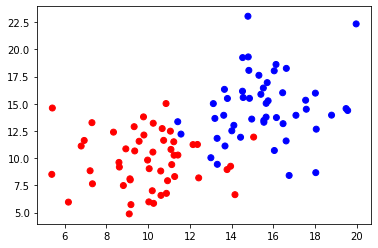

In [ ]:
plt.scatter(x = training_set['variable_1'], y = training_set['variable_2'], c = training_set['etiqueta'].map({'grupo_A': 'red', 'grupo_B': 'blue'}))

Creo un modelo de k vecinos más cercanos (con k = 10) y lo entreno.

In [6]:
from sklearn import neighbors

X = training_set.loc[:, training_set.columns != 'etiqueta']

y = training_set['etiqueta']

k = 10

knn = neighbors.KNeighborsClassifier(n_neighbors = k)

knn.fit(X, y)

KNeighborsClassifier(n_neighbors=10)

Testeo y calculo las métricas.

In [7]:
X_test = test_set.loc[:, training_set.columns != 'etiqueta']

predicciones = knn.predict(X_test)

In [8]:
from sklearn.metrics import classification_report

print(classification_report(test_set['etiqueta'], predicciones))

              precision    recall  f1-score   support

     grupo_A       0.96      0.92      0.94        50
     grupo_B       0.92      0.96      0.94        50

    accuracy                           0.94       100
   macro avg       0.94      0.94      0.94       100
weighted avg       0.94      0.94      0.94       100



### Experimentos con 2 dimensiones y distintos parámetros

In [9]:
etiquetas = ['grupo_A', 'grupo_B']
dim = 2
valores_N = [100, 10000]
valores_k = [3, 10, 30]
valores_centroides = [[[10, 10], [15, 15]], # Dos centroides relativamente cercanos entre sí.
                      [[10, 10], [25, 25]]] # Dos centroides más alejados.
valores_covarianzas = [[[[5, 0], [0, 5]], # Covarianzas relativamente bajas.
                        [[4, 0], [0, 4]]],
                       [[[15, 0], [0, 15]], # Covarianzas relativamente altas.
                        [[20, 0], [0, 20]]]]

In [10]:
columnas = ['dimensiones', 'n_por_grupo', 'k', 'centroides', 'covarianzas', 'recall', 'precision', 'f1-score']

resultados = pd.DataFrame(columns = columnas)

for n in valores_N:
  for k in valores_k:
    for centroides in valores_centroides:
      for covarianzas in valores_covarianzas:

        prueba = {}

        prueba['dimensiones'] = [dim]

        prueba['n_por_grupo'] = [n]

        prueba['k'] = [k]

        prueba['centroides'] = [centroides]

        prueba['covarianzas'] = [covarianzas]

        dataset = crear_dataset_balanceado(etiquetas = etiquetas,
                                           datos_por_grupo = n,
                                           dimensiones = dim,
                                           centroides = centroides,
                                           covarianzas = covarianzas)

        training_set, test_set = train_test_split(dataset, test_size=0.5)

        X = training_set.loc[:, training_set.columns != 'etiqueta']

        y = training_set['etiqueta']

        knn = neighbors.KNeighborsClassifier(n_neighbors = k)

        knn.fit(X, y)

        X_test = test_set.loc[:, training_set.columns != 'etiqueta']

        predicciones = knn.predict(X_test)

        report = classification_report(test_set['etiqueta'], predicciones, output_dict = True)['macro avg']
        
        prueba['recall'] = [report['recall']]

        prueba['precision'] = [report['precision']]

        prueba['f1-score'] = [report['f1-score']]
        
        resultado_prueba = pd.DataFrame.from_dict(prueba)

        resultados = pd.concat([resultados, resultado_prueba], ignore_index = True)

Las métricas más bajas corresponden a los casos con grupos con centroides más cercanos entre sí y con mayor covarianza.

In [ ]:
resultados

,dimensiones,n_por_grupo,k,centroides,covarianzas,recall,precision,f1-score
0,2,100,3,"[[10, 10], [15, 15]]","[[[5, 0], [0, 5]], [[4, 0], [0, 4]]]",0.930000,0.931554,0.929937
1,2,100,3,"[[10, 10], [15, 15]]","[[[15, 0], [0, 15]], [[20, 0], [0, 20]]]",0.690000,0.690686,0.689721
2,2,100,3,"[[10, 10], [25, 25]]","[[[5, 0], [0, 5]], [[4, 0], [0, 4]]]",1.000000,1.000000,1.000000
3,2,100,3,"[[10, 10], [25, 25]]","[[[15, 0], [0, 15]], [[20, 0], [0, 20]]]",0.990000,0.990196,0.989999
4,2,100,10,"[[10, 10], [15, 15]]","[[[5, 0], [0, 5]], [[4, 0], [0, 4]]]",0.910000,0.910164,0.909991
5,2,100,10,"[[10, 10], [15, 15]]","[[[15, 0], [0, 15]], [[20, 0], [0, 20]]]",0.690000,0.693798,0.688474
6,2,100,10,"[[10, 10], [25, 25]]","[[[5, 0], [0, 5]], [[4, 0], [0, 4]]]",1.000000,1.000000,1.000000
7,2,100,10,"[[10, 10], [25, 25]]","[[[15, 0], [0, 15]], [[20, 0], [0, 20]]]",0.990000,0.990196,0.989999
8,2,100,30,"[[10, 10], [15, 15]]","[[[5, 0], [0, 5]], [[4, 0], [0, 4]]]",0.940000,0.940705,0.939976
9,2,100,30,"[[10, 10], [15, 15]]","[[[15, 0], [0, 15]], [[20, 0], [0, 20]]]",0.700000,0.705255,0.698068


### Experimentos con más de 2 dimensions

In [11]:
etiquetas = ['grupo_A', 'grupo_B']
dim = 3
valores_N = [100, 10000]
valores_k = [3, 10, 30]
valores_centroides = [[[10, 10, 10], [15, 15, 15]], # Dos centroides relativamente cercanos entre sí.
                      [[10, 10, 10], [25, 25, 25]]] # Dos centroides más alejados.
valores_covarianzas = [[[[5, 0, 0], [0, 5, 0], [0, 0, 5]], # Covarianzas relativamente bajas.
                        [[4, 0, 0], [0, 4, 0], [0, 0, 4]]],
                       [[[15, 0, 0], [0, 15, 0], [0, 0, 15]], # Covarianzas relativamente altas.
                        [[20, 0, 0], [0, 20, 0], [0, 0, 20]]]]

In [12]:
for n in valores_N:
  for k in valores_k:
    for centroides in valores_centroides:
      for covarianzas in valores_covarianzas:

        prueba = {}

        prueba['dimensiones'] = [dim]

        prueba['n_por_grupo'] = [n]

        prueba['k'] = [k]

        prueba['centroides'] = [centroides]

        prueba['covarianzas'] = [covarianzas]

        dataset = crear_dataset_balanceado(etiquetas = etiquetas,
                                           datos_por_grupo = n,
                                           dimensiones = dim,
                                           centroides = centroides,
                                           covarianzas = covarianzas)

        training_set, test_set = train_test_split(dataset, test_size=0.5)

        X = training_set.loc[:, training_set.columns != 'etiqueta']

        y = training_set['etiqueta']

        knn = neighbors.KNeighborsClassifier(n_neighbors = k)

        knn.fit(X, y)

        X_test = test_set.loc[:, test_set.columns != 'etiqueta']

        predicciones = knn.predict(X_test)

        report = classification_report(test_set['etiqueta'], predicciones, output_dict = True)['macro avg']
        
        prueba['recall'] = [report['recall']]

        prueba['precision'] = [report['precision']]

        prueba['f1-score'] = [report['f1-score']]
        
        resultado_prueba = pd.DataFrame.from_dict(prueba)

        resultados = pd.concat([resultados, resultado_prueba], ignore_index = True)

Con tres dimensiones se observa algo similar a los resultados con dos dimensiones. Las métricas más bajas se dan en los casos con centroides más cercanos entre sí y mayores covarianzas. De entre estos casos, el valor más bajo de f1 corresponde a los valores n_por_grupo = 100 y k = 30. 

In [ ]:
resultados[resultados['dimensiones'] == 3]

,dimensiones,n_por_grupo,k,centroides,covarianzas,recall,precision,f1-score
24,3,100,3,"[[10, 10, 10], [15, 15, 15]]","[[[5, 0, 0], [0, 5, 0], [0, 0, 5]], [[4, 0, 0]...",0.962963,0.960000,0.959936
25,3,100,3,"[[10, 10, 10], [15, 15, 15]]","[[[15, 0, 0], [0, 15, 0], [0, 0, 15]], [[20, 0...",0.861111,0.877049,0.849261
26,3,100,3,"[[10, 10, 10], [25, 25, 25]]","[[[5, 0, 0], [0, 5, 0], [0, 0, 5]], [[4, 0, 0]...",1.000000,1.000000,1.000000
27,3,100,3,"[[10, 10, 10], [25, 25, 25]]","[[[15, 0, 0], [0, 15, 0], [0, 0, 15]], [[20, 0...",1.000000,1.000000,1.000000
28,3,100,10,"[[10, 10, 10], [15, 15, 15]]","[[[5, 0, 0], [0, 5, 0], [0, 0, 5]], [[4, 0, 0]...",0.962963,0.960000,0.959936
29,3,100,10,"[[10, 10, 10], [15, 15, 15]]","[[[15, 0, 0], [0, 15, 0], [0, 0, 15]], [[20, 0...",0.842593,0.865079,0.828612
30,3,100,10,"[[10, 10, 10], [25, 25, 25]]","[[[5, 0, 0], [0, 5, 0], [0, 0, 5]], [[4, 0, 0]...",1.000000,1.000000,1.000000
31,3,100,10,"[[10, 10, 10], [25, 25, 25]]","[[[15, 0, 0], [0, 15, 0], [0, 0, 15]], [[20, 0...",1.000000,1.000000,1.000000
32,3,100,30,"[[10, 10, 10], [15, 15, 15]]","[[[5, 0, 0], [0, 5, 0], [0, 0, 5]], [[4, 0, 0]...",0.981481,0.979167,0.979928
33,3,100,30,"[[10, 10, 10], [15, 15, 15]]","[[[15, 0, 0], [0, 15, 0], [0, 0, 15]], [[20, 0...",0.794686,0.826203,0.776786


## Ejercicio 3.2

Creo el dataset, y pruebo distintos parámetros para el clasificador usando GridSearch.

In [13]:
etiquetas = ['grupo_A', 'grupo_B']
n = 10000
dim = 2
centroides = [[10, 10],
              [16, 14]]
covarianzas = [[[15, 0], [0, 15]],
               [[20, 0], [0, 20]]]

In [14]:
dataset = crear_dataset_balanceado(etiquetas = etiquetas,
                                   datos_por_grupo = n,
                                   dimensiones = dim,
                                   centroides = centroides,
                                   covarianzas = covarianzas)

In [15]:
training_set, test_set = train_test_split(dataset, test_size=0.5)

In [16]:
X = training_set.loc[:, training_set.columns != 'etiqueta']

y = training_set['etiqueta']

parametros = {'n_neighbors': [3,10,50,100], 'weights': ['uniform', 'distance']}

knn = neighbors.KNeighborsClassifier()

from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(knn, parametros)

clf.fit(X, y)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 10, 50, 100],
                         'weights': ['uniform', 'distance']})

Genero un dataframe con los parámetros y los resultados correspondientes.

In [ ]:
resultados_cv = pd.DataFrame()

resultados_cv['k'] = clf.cv_results_['param_n_neighbors'].data

resultados_cv['weight'] = clf.cv_results_['param_weights'].data

resultados_cv['score'] = clf.cv_results_['mean_test_score']

En este caso, los mejores resultados se obtuvieron con k = 100 y weights = 'uniform'.

In [ ]:
resultados_cv

,k,weight,score
0,3,uniform,0.7615
1,3,distance,0.7500
2,10,uniform,0.7923
3,10,distance,0.7824
4,50,uniform,0.8057
5,50,distance,0.8006
6,100,uniform,0.8080
7,100,distance,0.8039


## Ejercicio 3.3

### Importar Datos


In [200]:
attributes_spotify = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectBOM/data/attributes_spotify.csv")

In [201]:
training_set, test_set = train_test_split(attributes_spotify, test_size=0.2, random_state = 7)

In [130]:
training_set.head()

,Unnamed: 0,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
167,167,0.217000,0.704,185437,0.657,0.000118,10,0.0888,-7.172,0,0.3500,150.058,4.0,0.804,1,Callie (feat. Vic Mensa),Donnie Trumpet
643,643,0.000891,0.806,297907,0.772,0.864000,6,0.1010,-14.369,1,0.0856,125.325,4.0,0.436,1,No Way Back,Adonis
1991,1991,0.000366,0.544,245133,0.788,0.000000,5,0.1410,-5.593,0,0.0474,148.121,4.0,0.821,0,Jenny,WALK THE MOON
188,188,0.019000,0.695,246521,0.940,0.800000,7,0.6230,-2.935,1,0.1270,100.262,4.0,0.337,1,N.O. Bounce,Big Freedia
1208,1208,0.076200,0.809,195853,0.628,0.000371,11,0.1130,-5.021,0,0.0561,130.008,4.0,0.797,0,Sexy Bitch (feat. Akon) - Featuring Akon;explicit,David Guetta


El dataset está balanceado:

In [165]:
training_set['target'].value_counts()

1    810
0    803
Name: target, dtype: int64

### Data Wrangling

Realizo las siguientes modificaciones teniendo en cuenta la [documentación de Spotify](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features) sobre el significado de las variables.

Convierto variables numéricas en booleanas considerando los puntos de corte indicados por la documentación. Hago esto porque creo que a la hora de elegir un outcome (si la canción gusta o no) importa más si una característica está presente o no que el valor de esa característica (por ejemplo, importa más saber si la canción es acústica que el valor numérico de acousticness). Aplico este razonamiento a las variables 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness' y 'valence'.

In [202]:
def convertir_variable(dataframe, variable, punto_de_corte):

  '''
  La función transforma una variable numérica en booleana.
  
  dataframe: pandas dataframe a convertir.
  variable: string con el nombre de la variable.
  punto_de_corte: float, los valores mayor a este número serán considerados True y el resto de los valores serán False.
  '''

  nueva_columna = dataframe[variable].apply(lambda x: True if x > punto_de_corte else False)

  return nueva_columna

In [203]:
puntos_de_corte = [{'variable': 'acousticness', 'punto_de_corte': 0.7}, # Uso 0.7 cuando la documentación no indica un punto de corte en particular.
                   {'variable': 'danceability', 'punto_de_corte': 0.7},
                   {'variable': 'energy', 'punto_de_corte': 0.7},
                   {'variable': 'instrumentalness', 'punto_de_corte': 0.5},
                   {'variable': 'liveness', 'punto_de_corte': 0.7},
                   {'variable': 'speechiness', 'punto_de_corte': 0.33},
                   {'variable': 'valence', 'punto_de_corte': 0.7}]

for elemento in puntos_de_corte:

  training_set[elemento['variable']] = convertir_variable(dataframe = training_set, variable = elemento['variable'], punto_de_corte = elemento['punto_de_corte'])


Transformo la variable 'duration_ms' a categórica con tres niveles: 0 (duración corta), 1 (duración media) y 2 (duración larga). Elijo 2:30 mins y 4:00 mins como puntos de corte.

In [204]:
def clasificar_duracion(duracion_ms):

  if duracion_ms < 150000:

    clase = 0

  elif duracion_ms > 240000:

    clase = 2

  else:

    clase = 1

  return clase

training_set['duration_ms'] = training_set['duration_ms'].apply(lambda x: clasificar_duracion(x))

Transformo la variable 'song_title' a 'idioma', ya que el título en sí no sería útil para el modelo, pero puede servir para identificar el idioma de la canción (el cual, creo, es una variable que puede influir en el outcome).
  
  Nota: La función para detectar idiomas suele tener errores, por lo que en vez de tomar el nombre del idioma la uso solo para identificar si la canción está en inglés.

In [205]:
from langdetect import detect

def detectar_idioma(string):

  try:

    return detect(string) == 'en'  

  except:

    return False

training_set['idioma'] = training_set['song_title'].apply(lambda x: detectar_idioma(x))

Convierto la variable 'artist' a una variable booleana con valor True si la frecuencia de canciones de ese o esa artista es relativamente alta, porque este dato seguramente influya en el outcome.texto en negrita

In [206]:
canciones_por_artista = training_set['artist'].value_counts().rename_axis('artista').reset_index(name='cantidad')

artistas_favoritos = canciones_por_artista[canciones_por_artista['cantidad'] > 3]['artista'].to_list()

In [121]:
artistas_favoritos[0:10]

['Drake',
 'Disclosure',
 'Rick Ross',
 'WALK THE MOON',
 'Kanye West',
 'Big Time Rush',
 'Crystal Castles',
 'FIDLAR',
 'The Chainsmokers',
 'Skrillex']

In [207]:
training_set['artista_favorito'] = training_set['artist'].apply(lambda x: x in artistas_favoritos)

Creo variables dummy para las variables categóricas (duracion_ms y key).

In [209]:
training_set = pd.get_dummies(training_set, columns = ['duration_ms', 'key'], drop_first = True)

Normalizo las variables numéricas (loudness, tempo y time_signature).

In [219]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(training_set[['loudness', 'tempo', 'time_signature']])

training_set[['loudness', 'tempo', 'time_signature']] = scaler.transform(training_set[['loudness', 'tempo', 'time_signature']])

Elimino las columnas que no sirven.

In [222]:
training_set.drop(['Unnamed: 0', 'song_title', 'artist'], axis = 1, inplace = True)

In [223]:
training_set.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,time_signature,...,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11
167,False,True,False,False,False,0.790637,0,True,0.631532,0.75,...,0,0,0,0,0,0,0,0,1,0
643,False,True,True,True,False,0.571150,1,False,0.478696,0.75,...,0,0,0,0,1,0,0,0,0,0
1991,False,False,True,False,False,0.838792,0,False,0.619563,0.75,...,0,0,0,1,0,0,0,0,0,0
188,False,False,True,True,False,0.919854,1,False,0.323821,0.75,...,0,0,0,0,0,1,0,0,0,0
1208,False,True,False,False,False,0.856237,0,False,0.507635,0.75,...,0,0,0,0,0,0,0,0,0,1


### Modelo de Clasificación

Entreno un modelo knn. Uso GridSearch para buscar la mejor combinación de parámetros.

In [234]:
X = training_set.loc[:, training_set.columns != 'target']

y = training_set['target']

parametros = {'n_neighbors': [20, 30, 40, 50, 60, 70, 80, 90, 100], 'weights': ['uniform', 'distance']}

knn = neighbors.KNeighborsClassifier()

clf = GridSearchCV(knn, parametros)

clf.fit(X, y)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [20, 30, 40, 50, 60, 70, 80, 90, 100],
                         'weights': ['uniform', 'distance']})

In [235]:
resultados_cv = pd.DataFrame()

resultados_cv['k'] = clf.cv_results_['param_n_neighbors'].data

resultados_cv['weight'] = clf.cv_results_['param_weights'].data

resultados_cv['score'] = clf.cv_results_['mean_test_score']

Las métricas más altas corresponden a k = 70 y weight = 'uniform'.

In [236]:
resultados_cv[resultados_cv['score'] == resultados_cv['score'].max()]

,k,weight,score
10,70,uniform,0.664621


In [237]:
modelo = neighbors.KNeighborsClassifier(n_neighbors = 70, weights = 'uniform')

modelo.fit(X, y)

KNeighborsClassifier(n_neighbors=70)

Aplico las funciones de data wrangling al test set y testeo el modelo.

In [238]:
puntos_de_corte = [{'variable': 'acousticness', 'punto_de_corte': 0.7},
                   {'variable': 'danceability', 'punto_de_corte': 0.7},
                   {'variable': 'energy', 'punto_de_corte': 0.7},
                   {'variable': 'instrumentalness', 'punto_de_corte': 0.5},
                   {'variable': 'liveness', 'punto_de_corte': 0.7},
                   {'variable': 'speechiness', 'punto_de_corte': 0.33},
                   {'variable': 'valence', 'punto_de_corte': 0.7}]

for elemento in puntos_de_corte:

  test_set[elemento['variable']] = convertir_variable(dataframe = test_set, variable = elemento['variable'], punto_de_corte = elemento['punto_de_corte'])

In [239]:
test_set['duration_ms'] = test_set['duration_ms'].apply(lambda x: clasificar_duracion(x))

In [240]:
test_set['idioma'] = test_set['song_title'].apply(lambda x: detectar_idioma(x))

In [241]:
test_set['artista_favorito'] = test_set['artist'].apply(lambda x: x in artistas_favoritos) # Uso la lista de artistas favoritos del training set.

In [242]:
test_set = pd.get_dummies(test_set, columns = ['duration_ms', 'key'], drop_first = True)

In [243]:
test_set[['loudness', 'tempo', 'time_signature']] = scaler.transform(test_set[['loudness', 'tempo', 'time_signature']])

In [244]:
test_set.drop(['Unnamed: 0', 'song_title', 'artist'], axis = 1, inplace = True)

In [245]:
X_test = test_set.loc[:, test_set.columns != 'target']

predicciones = modelo.predict(X_test)

La accuracy del modelo es de 0.65.

In [246]:
print(classification_report(test_set['target'], predicciones))

              precision    recall  f1-score   support

           0       0.60      0.76      0.67       194
           1       0.71      0.54      0.61       210

    accuracy                           0.65       404
   macro avg       0.66      0.65      0.64       404
weighted avg       0.66      0.65      0.64       404

